In [ ]:
import pandas as pd
import numpy as np
import os

df = pd.read_csv('./data/train.csv')
sub = pd.read_csv('./data/sample_submission.csv')

# Make sure sorted by date
df = df.sort_values(by='date')
sub = sub.sort_values(by='date')

# Format date as date
df["date"] = pd.to_datetime(df["date"]).dt.date
sub["date"] = pd.to_datetime(sub["date"]).dt.date

In [ ]:
df.head()

In [ ]:
# This is going to be a common problem to fix, but tracking is doubled 9/27/2017 and 6/12/2018

def fix_double_tracking(df, col, date_col="date"):
    df.loc[(df[date_col] <= pd.to_datetime("2018-06-12").date()) & (df[date_col] >= pd.to_datetime("2017-09-27").date()), col] = \
    df.loc[(df[date_col] <= pd.to_datetime("2018-06-12").date()) & (df[date_col] >= pd.to_datetime("2017-09-27").date()), col] / 2
    return df


In [ ]:
# sleep_hours between 9/27/2017 and 6/12/2018 is doubled and needs to be divided by 2
df = fix_double_tracking(df, "sleep_hours")

In [ ]:
df.sleep_hours.hist()

In [ ]:
# Fill in missing dates (for time series)

start_date = df["date"].min()
print(f"Start date: {start_date}")

end_date = df["date"].max()
print(f"End date: {end_date}")

date_range = pd.date_range(start=start_date, end=end_date, freq="D")
date_range = pd.DataFrame({"date": date_range})
date_range["date"] = date_range["date"].dt.date

df = date_range.merge(df, on="date", how="left")
print('missing days: ', df.sleep_hours.isna().sum())

In [ ]:
# forward fill the missing values/targets
df["sleep_hours"] = df["sleep_hours"].fillna(method="ffill")

In [ ]:
#plot df_sleep.sleep_hours as dots by df_sleep.date
df.plot.scatter(x='date', y='sleep_hours')

In [ ]:
# Median of sleep_hours
med = df.sleep_hours.median()
print(f"Median sleep hours: {med}")


In [ ]:
sub_median = sub.copy()
sub_median["sleep_hours"] = med
sub_median.to_csv("./submissions/submission_median.csv", index=False)
sub_median.head()

# kaggle competitions submit -c kaggle-pog-series-s01e04 -f ./submissions/submission_median.csv -m "Trying just all median"
# Score : 0.67685

In [ ]:
# Median of sleep_hours
mean = df.sleep_hours.mean()
print(f"Median sleep hours: {mean}")

In [ ]:
sub_mean = sub.copy()
sub_mean["sleep_hours"] = mean
sub_mean.to_csv("./submissions/submission_mean.csv", index=False)
sub_mean.head()

# kaggle competitions submit -c kaggle-pog-series-s01e04 -f ./submissions/submission_mean.csv -m "Trying just all mean"
# Score: 0.67396

In [ ]:
import pytz
from datetime import datetime, timedelta
from pandas.tseries.holiday import USFederalHolidayCalendar
### Time series Data ###

df["day_of_week"] = pd.to_datetime(df["date"]).dt.dayofweek # Day of the week
df["month"] = pd.to_datetime(df["date"]).dt.month # Month
df["is_weekend"] = df["day_of_week"].apply(lambda x: 1 if x >= 5 else 0) # is_weekend

cal = USFederalHolidayCalendar()
holidays = cal.holidays(start="2014-01-01", end="2023-12-31") 
df["is_holiday"] = df["date"].apply(lambda x: 1 if x in holidays else 0) # is_holiday
df["is_workday"] = 1-(df["is_weekend"] + df["is_holiday"]) # is_workday

In [ ]:
df.head()

In [ ]:
# Create submissions by median by DOW
sub_median_group = sub.copy()
med = df.groupby("day_of_week")["sleep_hours"].median()
sub_median_group["day_of_week"] = pd.to_datetime(sub_median_group["date"]).dt.dayofweek
sub_median_group["sleep_hours"] = sub_median_group["day_of_week"].map(med)
sub_median_group = sub_median_group.drop("day_of_week", axis=1)
sub_median_group.to_csv("./submissions/submission_median_group.csv", index=False)
sub_median_group.head()

# kaggle competitions submit -c kaggle-pog-series-s01e04 -f ./submissions/submission_median_group.csv -m "Trying all median by DOW"
# Score: 0.67406

In [ ]:
# Create submissions by median by DOW
sub_mean_group = sub.copy()
mean = df.groupby("day_of_week")["sleep_hours"].mean()
sub_mean_group["day_of_week"] = pd.to_datetime(sub_mean_group["date"]).dt.dayofweek
sub_mean_group["sleep_hours"] = sub_mean_group["day_of_week"].map(mean)
sub_mean_group = sub_mean_group.drop("day_of_week", axis=1)
sub_mean_group.to_csv("./submissions/submission_mean_group.csv", index=False)
sub_mean_group.head()

# kaggle competitions submit -c kaggle-pog-series-s01e04 -f ./submissions/submission_mean_group.csv -m "Trying all mean by DOW"
# Score: ________________

In [ ]:
# Submission by median by DOW and and is_workday
sub_median_group_workday = sub.copy()
med = df.groupby(["day_of_week", "is_workday"])["sleep_hours"].median()
sub_median_group_workday["day_of_week"] = pd.to_datetime(sub_median_group_workday["date"]).dt.dayofweek
sub_median_group_workday["is_workday"] = 1-(sub_median_group_workday["day_of_week"].apply(lambda x: 1 if x >= 5 else 0) + sub_median_group_workday["date"].apply(lambda x: 1 if x in holidays else 0))
sub_median_group_workday["sleep_hours"] = sub_median_group_workday[["day_of_week", "is_workday"]].apply(lambda x: med[x[0]][x[1]], axis=1)
sub_median_group_workday = sub_median_group_workday.drop(["day_of_week", "is_workday"], axis=1)
sub_median_group_workday.to_csv("./submissions/submission_median_group_workday.csv", index=False)
sub_median_group_workday.head()
# kaggle competitions submit -c kaggle-pog-series-s01e04 -f ./submissions/submission_median_group_workday.csv -m "Trying all median by DOW and is_workday"
# Score: __________________

In [ ]:
# Submission by mean by DOW and and is_workday
sub_mean_group_workday = sub.copy()
mean = df.groupby(["day_of_week", "is_workday"])["sleep_hours"].mean()
sub_mean_group_workday["day_of_week"] = pd.to_datetime(sub_mean_group_workday["date"]).dt.dayofweek
sub_mean_group_workday["is_workday"] = 1-(sub_mean_group_workday["day_of_week"].apply(lambda x: 1 if x >= 5 else 0) + sub_mean_group_workday["date"].apply(lambda x: 1 if x in holidays else 0))
sub_mean_group_workday["sleep_hours"] = sub_mean_group_workday[["day_of_week", "is_workday"]].apply(lambda x: mean[x[0]][x[1]], axis=1)
sub_mean_group_workday = sub_mean_group_workday.drop(["day_of_week", "is_workday"], axis=1)
sub_mean_group_workday.to_csv("./submissions/submission_mean_group_workday.csv", index=False)
sub_mean_group_workday.head()
# kaggle competitions submit -c kaggle-pog-series-s01e04 -f ./submissions/submission_mean_group_workday.csv -m "Trying all mean by DOW and is_workday"
# Score: ________________

In [ ]:
from glob import glob

csv_files = glob("./data/xml_export/*.csv")

# Keep what files have ~80% of the dates in the training data
unique_dates = set(df["date"])

match_threshold = 0.75 # Threshold for matching

def intersection_ratio(set1, set2):
    return len(set1 & set2) / len(set1)

matching_csvs = []
for csv_file in csv_files:
    csv_df = pd.read_csv(csv_file)  
    try: 
        csv_df["date"] = pd.to_datetime(csv_df["startDate"]).dt.date
    except:
        csv_df["date"] = pd.to_datetime(csv_df["dateComponents"]).dt.date # Some use dateComponents instead of startDate

    unique_creation_dates = set(csv_df)

    ratio = intersection_ratio(unique_dates, unique_creation_dates)

    if ratio >= match_threshold:
        matching_csvs.append(csv_file)

print("CSV files with at least 75% of the 'dates' from the original DataFrame:")
for matching_csv in matching_csvs:
    print(matching_csv)

In [ ]:

csv_df.loc[csv_df["date"] >= pd.to_datetime("2021-01-01").date()]

In [ ]:
list = ["test1", "test2", "test3"]


In [ ]:
# Datasets worth exploring
basal_energy_burned = pd.read_csv('./data/xml_export/BasalEnergyBurned.csv', low_memory=False)
body_mass = pd.read_csv('./data/xml_export/BodyMass.csv', low_memory=False)
flights_climbed = pd.read_csv('./data/xml_export/FlightsClimbed.csv', low_memory=False)
step_count = pd.read_csv('./data/xml_export/StepCount.csv', low_memory=False)
body_mass_index = pd.read_csv('./data/xml_export/BodyMassIndex.csv', low_memory=False)
distance_walking_running = pd.read_csv('./data/xml_export/DistanceWalkingRunning.csv', low_memory=False)


In [ ]:

def parse_xml_output(path):
    # Import the csv
    csv_df = pd.read_csv(path, low_memory=False)
    base_name = os.path.basename(path).split(".")[0]
    
    # BodyMassIndex we want to avg not sum
    if base_name == "BodyMassIndex":
        agg_func = "mean"
    else:
        agg_func = "sum"
    
    # Convert startDate and endDate columns to datetime objects
    csv_df["startDate"] = pd.to_datetime(csv_df["startDate"]).dt.tz_convert ("US/Eastern")
    csv_df["endDate"] = pd.to_datetime(csv_df["endDate"]).dt.tz_convert ("US/Eastern")
    # Create date & time column
    csv_df["date"] = pd.to_datetime(csv_df["startDate"]).dt.date
    csv_df["time"] = pd.to_datetime(csv_df["startDate"]).dt.time
    
    # Group by date and perform aggregations
    csv_df = csv_df.groupby("date").agg(
        max_start_time=pd.NamedAgg(column="startDate", aggfunc="max"),
        min_start_time=pd.NamedAgg(column="startDate", aggfunc="min"),
        max_end_time=pd.NamedAgg(column="endDate", aggfunc="max"),
        min_end_time=pd.NamedAgg(column="endDate", aggfunc="min"),
        value_sum=pd.NamedAgg(column="value", aggfunc=agg_func)
    ).reset_index()
    
    # Check if the dates match between min_start_time and max_end_time
    csv_df["dates_match"] = csv_df.apply(
        lambda row: row["min_start_time"].date() == row["max_end_time"].date(), axis=1)
    csv_df = csv_df.rename(columns={"value_sum": base_name})
    
    # Assert if dates match in all rows
    # assert csv_df["dates_match"].all(), "Dates do not match in some rows"
    
    # Trigonomic Hours
    csv_df[base_name+"_mx_st_hr_sin"] = np.sin(2 * np.pi * csv_df["max_start_time"].dt.hour / 24)
    csv_df[base_name+"_mx_st_hr_cos"] = np.cos(2 * np.pi * csv_df["max_start_time"].dt.hour / 24)
    csv_df[base_name+"_mn_st_hr_sin"] = np.sin(2 * np.pi * csv_df["min_start_time"].dt.hour / 24)
    csv_df[base_name+"_mn_st_hr_cos"] = np.cos(2 * np.pi * csv_df["min_start_time"].dt.hour / 24)
    csv_df[base_name+"_mx_et_hr_sin"] = np.sin(2 * np.pi * csv_df["max_end_time"].dt.hour / 24)
    csv_df[base_name+"_mx_et_hr_cos"] = np.cos(2 * np.pi * csv_df["max_end_time"].dt.hour / 24)
    csv_df[base_name+"_mn_et_hr_sin"] = np.sin(2 * np.pi * csv_df["min_end_time"].dt.hour / 24)
    csv_df[base_name+"_mn_et_hr_cos"] = np.cos(2 * np.pi * csv_df["min_end_time"].dt.hour / 24) 
    
    #! HIGHLY ILLEGAL FEATURE??? (Step Count basically calculates sleep time)
    # Hours between startDate and next startDate (lag = -1)
    csv_df[base_name+"_hours_between"] = (csv_df["min_start_time"].shift(-1) - csv_df["max_start_time"]).dt.total_seconds() / 3600
    
    #Fix double tracking
    csv_df = fix_double_tracking(csv_df, base_name)
    
    # Drop unnecessary columns
    # csv_df = csv_df.drop(columns=["max_start_time", "min_start_time", "max_end_time", "min_end_time", "dates_match"])

    return csv_df

## Basal Energy Burned

In [ ]:
basal_energy_burned.head()

In [ ]:
# Value is the only useful feature
# Group by date and sum (set alias to basal_energy_burned)

# NOTE: Summing assumes duplicate tracking is not occuring between devices

basal_energy_burned = parse_xml_output("./data/xml_export/BasalEnergyBurned.csv")
basal_energy_burned.head()

In [ ]:
# Check distribution
basal_energy_burned.BasalEnergyBurned.hist()

In [ ]:
basal_energy_burned.plot.scatter(x='date', y='BasalEnergyBurned')

Looks like Rob got a better tracker or became more serious about racking in 2021

# Body Mass

In [ ]:
body_mass.head()

In [ ]:
body_mass["date"] = pd.to_datetime(body_mass["startDate"]).dt.date
body_mass = body_mass.groupby("date").sum().reset_index()
body_mass = body_mass.rename(columns={"value": "body_mass"})
body_mass = fix_double_tracking(body_mass, "body_mass")
body_mass.head()

In [ ]:
# Check distribution
body_mass.body_mass.hist()

In [ ]:
body_mass.plot.scatter(x='date', y='body_mass')

## Flights Climbed

In [ ]:
flights_climbed.head()

In [ ]:
flights_climbed["date"] = pd.to_datetime(flights_climbed["startDate"]).dt.date
flights_climbed = flights_climbed.groupby("date").sum().reset_index()
flights_climbed = flights_climbed.rename(columns={"value": "flights_climbed"})
flights_climbed = fix_double_tracking(flights_climbed, "flights_climbed")
flights_climbed.head()

In [ ]:
# Check distribution
flights_climbed.flights_climbed.hist()

# Definitely lognormal

In [ ]:
flights_climbed.plot.scatter(x='date', y='flights_climbed')

Very weird data. Will have to explore further. Possible duplication?

## Step Count

In [ ]:
step_count.head()

In [ ]:
step_count["date"] = pd.to_datetime(step_count["startDate"]).dt.date
step_count = step_count.groupby("date").sum().reset_index()
step_count = step_count.rename(columns={"value": "step_count"})
step_count = fix_double_tracking(step_count, "step_count")
step_count.head()

In [ ]:
# Check distribution
step_count.step_count.hist()

#kind of lognormal but not quite

In [ ]:
step_count.plot.scatter(x='date', y='step_count')

## Body Mass Index
This is a slow changing variable


In [ ]:
body_mass_index.head()

In [ ]:
body_mass_index["date"] = pd.to_datetime(body_mass_index["startDate"]).dt.date
body_mass_index = body_mass_index.groupby("date").mean(numeric_only =True).reset_index() #! MEAN here
body_mass_index = body_mass_index.rename(columns={"value": "body_mass_index"})
body_mass_index = body_mass_index.drop(columns=["sourceVersion", "device"], axis=1)
body_mass_index.head()

In [ ]:
# Check distribution
body_mass_index.body_mass_index.hist()

In [ ]:
body_mass_index.plot.scatter(x='date', y='body_mass_index')

Not measured frequently in 2012-2015

## Distance Walking/Running

In [ ]:
distance_walking_running.head()

In [ ]:
distance_walking_running = parse_xml_output("./data/xml_export/DistanceWalkingRunning.csv")
distance_walking_running.head()

In [ ]:
# Check distribution
distance_walking_running.DistanceWalkingRunning.hist()

# Lognormal

In [ ]:
distance_walking_running.plot.scatter(x='date', y='DistanceWalkingRunning')

In [ ]:
# Extract the hour and minute information from the datetime column and convert it to minutes
distance_walking_running['time_minutes'] = distance_walking_running['min_start_time'].dt.hour * 60 + distance_walking_running['min_start_time'].dt.minute

# Define the bin size (in minutes)
bin_size = 60  # 1-hour bins

# Create the bins using numpy
bins = np.arange(0, 24*60 + bin_size, bin_size)

# Plot the histogram using seaborn's histplot with time bins
plt.figure(figsize=(10, 6))
sns.histplot(data=distance_walking_running, x='time_minutes', bins=bins, kde=True)
plt.xticks(range(0, 24*60+1, bin_size), [f'{i:02d}:00' for i in range(0, 24+1, bin_size//60)], rotation=45)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Frequency of Time')
plt.show()

In [ ]:
distance_walking_running['time'].dt.seconds

# Feature Engineering

In [ ]:
# Combine all data into one DataFrame

for d in [basal_energy_burned, body_mass, flights_climbed, step_count, body_mass_index, distance_walking_running]:
    df = df.merge(d, on="date", how="left")

# Time series data so use ffill
df = df.fillna(method="ffill")
# Note: also ffills sleep_hours 

df.head()

In [ ]:
# Interactions
df["distance_per_step"] = df["distance"] / df["step_count"] # To account for jumping, hiking, etc.
df["calorie_per_step"] = df["basal_energy_burned"] / df["step_count"] # To account for intensity of exercise
d["calorie_per_distance"] = df["basal_energy_burned"] / df["distance"] # Gym days vs. Outdoor days

df.head()

In [ ]:
# Time series predictions to come later
# Try a column for every sleep_hours for the past week


# YData Profiling


In [ ]:
from helper import POG4_Dataset

data = POG4_Dataset()

#print(df.columns.to_list())

In [ ]:
data.features

In [ ]:

df["sleep_h"].value_counts(normalize=True, dropna=False).iloc[0] > threshold]


In [ ]:
from ydata_profiling import ProfileReport

profile_main = ProfileReport(df, title="POG4 Profiling Report", explorative=True)
profile_main.to_file("data_profile_main.html")

profile_ts = ProfileReport(df, tsmode=True, sortby="date", title="Time-Series EDA", explorative=True)
profile_ts.to_file("data_profile_ts.html")

In [ ]:
# Merge Submissions test

from glob import glob

files = glob("./submissions/*.csv")

sub_all = pd.concat([pd.read_csv(f) for f in files], axis=0, ignore_index=True)
sub_all = sub_all.groupby("date")["sleep_hours"].mean().reset_index()
sub_all.to_csv("./submissions/submission_combined.csv", index=False)
sub_all.head()


In [ ]:
from data import POG4_Dataset

data = POG4_Dataset()
#data.create_lags()


In [ ]:
data.X.DistanceWalkingRunning_nhours_avg_avg.value_counts()

In [ ]:
for i in data.X.columns:
    print(i)

In [ ]:
print('nas', data.X.HeartRate_sleep_hours.isna().sum())
print(len(data.X))
data.X.HeartRate_sleep_hours.value_counts()

In [ ]:
data.X.HeartRate_sleep_hours.hist()

In [ ]:
import pandas as pd
print(pd.value_counts(data.X.dtypes))


In [ ]:
import pandas as pd
pd.concat([data.X_test.reset_index(drop=True), data.y_test.reset_index(drop=True)], axis=1).isna().sum().sum()

In [ ]:
1915/2508

In [ ]:
import wandb
import pandas as pd

api = wandb.Api()
runs = api.runs("sgobat/pog4_xgb_classifier")
runs_2 = api.runs("sgobat/pog4_xgb")
# Initialize a list to store feature importances from all runs
feature_importances_list = []

# Iterate through the runs and fetch feature importances
for run in runs:
    # Fetch logged feature importances from the current run
    feature_importances = {
        key.replace("feature/", ""): value
        for key, value in run.summary.items()
        if key.startswith("feature/")
    }
    
    # Append the fetched feature importances to the list
    feature_importances_list.append(feature_importances)


for run in runs_2:
    # Fetch logged feature importances from the current run
    feature_importances = {
        key.replace("feature/", ""): value
        for key, value in run.summary.items()
        if key.startswith("feature/")
    }
    
    # Append the fetched feature importances to the list
    feature_importances_list.append(feature_importances)

# Create a DataFrame from the list of feature importances
df = pd.DataFrame(feature_importances_list)

# Calculate the mean feature importances across all runs
mean_feature_importances = df.sum().sort_values(ascending=False)

In [ ]:
with pd.option_context("display.max_rows", 1000):
    display(mean_feature_importances)

In [ ]:
feat_imp_threshold = mean_feature_importances.median() #- 1*mean_feature_importances.std()
print(feat_imp_threshold)

for i in mean_feature_importances.index:
    if mean_feature_importances[i] > feat_imp_threshold:
        print(i)

In [ ]:
 # Get first doy_mean where is_tuesday == 1
df.loc[df["is_tuesday"] == 1, "doy_mean"]


In [ ]:
[
"AppleStandTime_hrs_btween",
"BodyMassIndex_hrs_btween",
"OxygenSaturation_hrs_btween",
"is_weekend",
"appleExerciseTime",
"AppleStandTime",
"AppleStandHour_hrs_btween",
"VO2Max",
"AppleExerciseTime_hrs_btween",
"dow_median",
"appleStandHours",
"AppleStandTime_night_hours",
"AppleExerciseTime",
"day_of_week",
"avg_endDate_max_sin",
"max_startDate_min_hr",
"activeEnergyBurned",
"avg_startDate_min_sin",
"avg_startDate_min_hr",
"calorie_per_step",
"DistanceWalkingRunning_night_hours",
"month_sin",
"HeadphoneAudioExposure",
"avg_startDate_min_cos",
"max_endDate_min_hr",
"FlightsClimbed_hrs_btween",
"avg_endDate_min_sin",
"avg_endDate_max_cos",
"calorie_per_distance",
"HeartRateVariabilitySDNN_hrs_btween",
"DistanceWalkingRunning_hrs_btween",
"min_endDate_max_hr",
"StepCount_night_hours",
"FlightsClimbed_night_hours",
"distance_per_step",
"day_of_year",
"max_startDate_max_hr",
"min_endDate_min_hr",
"min_startDate_min_hr",
"StepCount_hrs_btween",
"BodyMassIndex",
"VO2Max_hrs_btween",
"doy_sin",
"month",
"month_cos",
"avg_startDate_max_sin",
"DistanceWalkingRunning",
"HeadphoneAudioExposure_hrs_btween",
"AppleExerciseTime_night_hours",
]

In [ ]:
import pandas as pd
apple_stand_time = pd.read_csv("./data/xml_export/AppleStandTime.csv", low_memory=False)

In [ ]:
df = apple_stand_time.copy()

def calculate_night_hours(df):
    df['startDate'] = pd.to_datetime(df['startDate'])
    df['endDate'] = pd.to_datetime(df['endDate'])

    # Define the time range for night time
    start_hour = 20  # 8 PM
    end_hour = 8  # 8 AM

    df = df[((df['startDate'].dt.hour >= start_hour) & (df['startDate'].dt.hour < 24)) |
                ((df['endDate'].dt.hour >= 0) & (df['endDate'].dt.hour < end_hour))]

    df['adjusted_startDate'] = (df['startDate'] - pd.to_timedelta('12:00:00')).dt.date # Subtract 12 hours from startDate
    df = df.groupby(['adjusted_startDate', 'sourceName']).agg(startDate=('startDate', 'min'), endDate=('endDate', 'max'), totalValue=('value', 'sum')).reset_index()
    df["night_hours"] = (df['endDate'] - df['startDate']).dt.total_seconds() / 3600

    return df

df = calculate_night_hours(df)
df.head(10)

In [ ]:
df.night_hours.hist()

In [ ]:
#See where sourcename is Rob’s Apple Watch
df[df['sourceName'] == "Rob's Apple Watch"]

In [ ]:
import pandas as pd
df = apple_stand_time.copy()

# Assuming your dataframe is named df, and has columns 'startDate' and 'endDate'
# Ensure the columns are in datetime format
df['startDate'] = pd.to_datetime(df['startDate'])
df['endDate'] = pd.to_datetime(df['endDate'])

# Define the time range for night time
start_hour = 20  # 8 PM
end_hour = 8  # 8 AM

# Filter the dataframe based on the specified time range
df_night = df[((df['startDate'].dt.hour >= start_hour) & (df['startDate'].dt.hour < 24)) |
              ((df['endDate'].dt.hour >= 0) & (df['endDate'].dt.hour < end_hour))]



# Group by the date and find min startDate and max endDate
df_night['startDate_date'] = df_night['startDate'].dt.date
df_night['endDate_date'] = df_night['endDate'].dt.date
df_night_grouped = df_night.groupby(['startDate_date', 'endDate_date']).agg({'startDate': 'min', 'endDate': 'max'}).reset_index()

# Hours beteween start and enddate
df_night_grouped['hrs_btween'] = (df_night_grouped['endDate'] - df_night_grouped['startDate']).dt.total_seconds() / 3600

# Display the resul
df_night_grouped.head(10)



In [ ]:
from data import POG4_Dataset
data = POG4_Dataset()

In [ ]:
data.train_test_split()
data.preprocess_data()

In [ ]:
data.X_test

In [ ]:
0.8*579


In [ ]:
import pandas as pd

d = pd.concat([data.y,data.X], axis=1)
d.to_csv("./regression.csv", index=False)
print(d)

In [ ]:
 for i in data.X.columns:
     print(i)


In [ ]:
data.X["AppleStandTime_night_hours"].plot()

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

import numpy as np

import xgboost as xgb

# Mean all columns that end in night_hours
X = data.X[1000:].filter(like="night_hours")
y = data.y[1000:]


model = xgb.XGBRegressor(gpu_id=0, tree_method="gpu_hist", random_state=42)

# Set up the cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Scaler
scaler = StandardScaler()

# Imputer 
imputer = SimpleImputer(strategy="mean")

pipeline = Pipeline(steps=[("imputer", imputer), ("scaler", scaler), ("model", model)])

# Perform cross-validation and calculate metrics
cv_scores = cross_val_score(model, X, y, cv=tscv, scoring="neg_mean_squared_error")
rmse_scores = np.sqrt(-cv_scores)
avg_rmse = np.mean(rmse_scores)
print(f"Average RMSE: {avg_rmse:.2f}")

### Stair Ascent/Descent

In [ ]:
ascent = pd.read_csv("./data/xml_export/StairAscentSpeed.csv", low_memory=False)
ascent["type"] = "ascent"
descent = pd.read_csv("./data/xml_export/StairDescentSpeed.csv", low_memory=False)
descent["type"] = "descent"

stairs = pd.concat([ascent, descent], axis=0)
stairs.head()

In [ ]:
df = stairs[stairs["value"] >= 1] # Optional?

df['startDate'] = pd.to_datetime(df['startDate']).dt.tz_localize(None)
df['endDate'] = pd.to_datetime(df['endDate']).dt.tz_localize(None)

df = df.sort_values(by=['startDate', 'endDate'])

# Get the date range in the dataframe
min_date = df['startDate'].min().date()
max_date = df['endDate'].max().date()

# Initialize an empty list to store the results
results = []

# Loop through each date in the range
for date in pd.date_range(min_date, max_date):
    # startSleep time boundaries - Based on analysis of train_detailed
    start_day = pd.Timestamp.combine(date, pd.Timestamp('21:30:00').time())
    end_day = pd.Timestamp.combine(date + pd.DateOffset(1), pd.Timestamp('01:30:00').time())
    
    # endSleep time boundaries - Based on analysis of train_detailed
    start_night = pd.Timestamp.combine(date + pd.DateOffset(1), pd.Timestamp('06:30:00').time())
    end_night = pd.Timestamp.combine(date + pd.DateOffset(1), pd.Timestamp('9:30:00').time())

    # Filter the dataframe for max_endDate
    mask_endDate = ((df['endDate'] >= start_day)) & ((df['endDate'] <= end_day))
    filtered_df_endDate = df[mask_endDate]

    # Filter the dataframe for min_startDate
    mask_startDate = ((df['startDate'] >= start_night)) & ((df['startDate'] <= end_night))
    filtered_df_startDate = df[mask_startDate]

    # Find max_endDate and min_startDate
    min_endDate = filtered_df_endDate['endDate'].min() # if not filtered_df_endDate.empty else pd.to_datetime(start_day)
    max_endDate = filtered_df_endDate['endDate'].max() # if not filtered_df_endDate.empty else pd.to_datetime(end_day)
    min_startDate = filtered_df_startDate['startDate'].min() # if not filtered_df_startDate.empty else pd.to_datetime(start_night)
    max_startDate = filtered_df_startDate['startDate'].max() # if not filtered_df_startDate.empty else pd.to_datetime(end_night)

    # Append the results to the list
    results.append({
        'date': date,
        'min_endDate': min_endDate, # Min Possible Start Sleeping
        'max_endDate': max_endDate, # Max Possible Start Sleeping
        'min_startDate': min_startDate, # Min Possible End Sleeping
        'max_startDate': max_startDate # Max Possible End Sleeping
    })

# Convert the results to a dataframe and return
result_df = pd.DataFrame(results)

# Time Differences in hours # Attempt to manually calculate sleep time - doesn't work, but still useful
result_df["nhours_min_min"] = (result_df["min_startDate"] - result_df["min_endDate"]).dt.total_seconds() / 3600
result_df["nhours_min_max"] = (result_df["min_startDate"] - result_df["max_endDate"]).dt.total_seconds() / 3600
result_df["nhours_max_min"] = (result_df["max_startDate"] - result_df["min_endDate"]).dt.total_seconds() / 3600
result_df["nhours_max_max"] = (result_df["max_startDate"] - result_df["max_endDate"]).dt.total_seconds() / 3600

# Hours
result_df["min_endDate_hr"] = result_df["min_endDate"].dt.hour
result_df["max_endDate_hr"] = result_df["max_endDate"].dt.hour
result_df["min_startDate_hr"] = result_df["min_startDate"].dt.hour
result_df["max_startDate_hr"] = result_df["max_startDate"].dt.hour

In [ ]:
result_df.nhours_min_max.isna().value_counts()

In [ ]:
import pandas as pd

# Read the CSV file
df = pd.read_csv("./data/train_detailed.csv", low_memory=False)

# Remove rows where "value" is HKCategoryValueSleepAnalysisInBed
df = df[df["value"] != "HKCategoryValueSleepAnalysisInBed"]

# Convert startDate and endDate columns to datetime objects
df["startDate"] = pd.to_datetime(df["startDate"])
df["endDate"] = pd.to_datetime(df["endDate"])

# Create adjusted_start_date column by subtracting 12 hours from startDate
df['adjusted_start_date'] = (df['startDate'] - pd.DateOffset(hours=12)).dt.date

# Save all unique adjusted_start_date values
unique_dates = pd.DataFrame(df["adjusted_start_date"].unique(), columns=["adjusted_start_date"])

# Filter rows with startDate hours >= 22 or endDate hours <= 10
df = df[(df["startDate"].dt.hour >= 22) | (df["endDate"].dt.hour <= 10)]

# Group by adjusted_start_date and get the min startDate and max endDate
df = df.groupby("adjusted_start_date").agg({"startDate": "min", "endDate": "max"}).reset_index()

# Convert startDate and endDate to hours since midnight
df["startDate"] = df["startDate"].dt.hour + df["startDate"].dt.minute / 60 + df["startDate"].dt.second / 3600
df["endDate"] = df["endDate"].dt.hour + df["endDate"].dt.minute / 60 + df["endDate"].dt.second / 3600

# If startDate is less than 12, add 24 hours
df.loc[df["startDate"] < 12, "startDate"] += 24

# Merge the results with the unique_dates DataFrame
final_df = unique_dates.merge(df, on="adjusted_start_date", how="left").fillna(method="ffill").fillna(method="bfill")



In [ ]:
final_df.endDate.hist()

In [ ]:
final_df.startDate.hist()

In [1]:
from data import POG4_Dataset

data = POG4_Dataset()

INFO - Creating XML data
INFO - Creating activity data
INFO - Missing days: 87
INFO - Featurizing time series data
INFO - Creating interactions...


In [2]:
data.train.slp_RespiratoryRate_hrs_min_max.round(0).value_counts()

slp_RespiratoryRate_hrs_min_max
6.0    66
Name: count, dtype: int64

In [ ]:
import pandas as pd

train = data.train[(data.train['date'] >= pd.to_datetime('2018-09-25').date()) & (data.train['date'] <= pd.to_datetime('2021-11-30').date())]

# Using cross-validation so concat the train and test sets
X = train.drop(['sleep_hours', 'date'], axis=1)
y = train.sleep_hours.fillna(method="ffill")

In [ ]:
X

In [ ]:
import xgboost as xgb

xgb.XGBRegressor().fit(X, y)

In [ ]:
print(len(data.X))
print(len(data.sleep_times))

In [ ]:
import pandas as pd
import datetime as dt

def process_heart_rate_data(filename, interval_minutes):
    df = pd.read_csv(filename, low_memory=False)

    # Keep only startDate, endDate, and value columns
    df = df[["startDate", "endDate", "value"]]

    df['startDate'] = pd.to_datetime(df['startDate'])
    df['startDate'] = df['startDate'] - pd.Timedelta(hours=12)

    df['date'] = df['startDate'].dt.date

    def round_time_to_nearest_interval(time):
        minutes = (time.hour * 60) + time.minute
        rounded_minutes = round(minutes / interval_minutes) * interval_minutes
        return dt.time(hour=(rounded_minutes // 60) % 24, minute=rounded_minutes % 60)

    df['time'] = df['startDate'].dt.time.map(round_time_to_nearest_interval)

    df_grouped = df.groupby(['date', 'time'])['value'].mean().reset_index()

    df_pivot = df_grouped.pivot_table(index='date', columns='time', values='value').reset_index()

    df_pivot.set_index('date', inplace=True)

    time_start = dt.time(hour=9)
    time_end = dt.time(hour=21)
    df_filtered = df_pivot.loc[:, (df_pivot.columns >= time_start) & (df_pivot.columns <= time_end)]


    def add_12_hours_to_time(time_obj):
        datetime_obj = dt.datetime.combine(dt.date(1, 1, 1), time_obj)
        datetime_obj += dt.timedelta(hours=12)
        return datetime_obj.time()

    df_filtered = df_filtered.rename(columns=add_12_hours_to_time)
    df_filtered.iloc[:, 1:] = df_filtered.iloc[:, 1:].interpolate(axis=1).ffill(axis=1).bfill(axis=1)
    df_filtered = df_filtered.reset_index()

    return df_filtered

filename = "./data/xml_export/HeartRate.csv"
interval_minutes = 5

df_filtered = process_heart_rate_data(filename, interval_minutes)


df_filtered

In [ ]:
df_filtered.shape

In [ ]:
import pandas as pd
import numpy as np
import pytz

def process_sleep_data(df, freq='1min', start_date='2020-09-26 00:00:00', end_date='2023-03-17 00:00:00'):
    #exclude where valud is HKCategoryValueSleepAnalysisInBed
    df = df.drop(df[df['value'] == 'HKCategoryValueSleepAnalysisInBed'].index)
    
    # Parse dates and times
    df['startDate'] = pd.to_datetime(df['startDate'])
    df['endDate'] = pd.to_datetime(df['endDate'])

    # Create the date range
    expanded_df = pd.DataFrame()
    expanded_df["date"] = pd.date_range(start_date, end_date, freq=freq, tz=pytz.FixedOffset(-240))

    # 1 if between startDate and endDate, 0 otherwise
    expanded_df["value"] = 0
    for _, row in df.iterrows():
        mask = (expanded_df['date'] >= row['startDate']) & (expanded_df['date'] <= row['endDate'])
        expanded_df.loc[mask, 'value'] = 1
        
    expanded_df = expanded_df.rename(columns={'value': 'sleep'})

    return expanded_df

def preprocess_feature_data(df, col_name, freq='1min', smoothing = 3, start_date='2020-09-26 00:00:00', end_date='2023-03-17 00:00:00'):
    df = df[(df['startDate'] >= start_date) & (df['startDate'] <= end_date)]
    
    df = pd.melt(df, id_vars=['value'], value_vars=['startDate', 'endDate'], value_name='date')
    df = df.groupby('date', as_index=False).mean(numeric_only=True)
    df = df.sort_values(by='date')
    
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')
    df = df.resample(freq).mean()
    
    #df = df.interpolate().rolling(smoothing, center=True).mean()
    df = df.fillna(method="ffill").fillna(method="bfill")
    
    df = df.reset_index()
    df = df.rename(columns={'date': 'date', 'value': col_name})
    
    return df

sleep_data = process_sleep_data(pd.read_csv('./data/train_detailed.csv', low_memory=False))


hr_data = preprocess_feature_data(pd.read_csv('./data/xml_export/RespiratoryRate.csv', low_memory=False), 'hr')




In [ ]:
df = pd.merge(sleep_data, hr_data, on='date', how='outer')
df = df.set_index("date")
df = df[:'2021-12-31'] 

df.head()

In [ ]:
df.hr = df.hr.rolling(3, center=True).mean()

In [ ]:
# Plot hr and sleep on seperate axis
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

slice = df['2021-12-14':'2021-12-15']

fig, ax1 = plt.subplots(figsize=(20, 10))

ax1.set_xlabel('date')
ax1.set_ylabel('hr', color='tab:red')
ax1.plot(slice.index, slice['hr'], color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('sleep', color='tab:blue')  # we already handled the x-label with ax1
ax2.plot(slice.index, slice['sleep'], color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

# plot rolling average hr
# ax3 = ax1.twinx()

# ax3.set_ylabel('hr', color='tab:orange')
# ax3.plot(slice.index, slice['hr'].rolling(60).mean(), color='tab:orange')
# ax3.tick_params(axis='y', labelcolor='tab:orange')


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


In [ ]:
def create_lags(df, column_name, n_lags):
    bckwd_columns = [df[column_name].shift(i).fillna(method="bfill").fillna(method="ffill") for i in range(1, n_lags+1)]
    fwd_columns = [df[column_name].shift(-i).fillna(method="bfill").fillna(method="ffill") for i in range(1, n_lags+1)]
    bckwd_names = [f"{column_name}_bckwd_{i}" for i in range(1, n_lags+1)]
    fwd_names = [f"{column_name}_fwd_{i}" for i in range(1, n_lags+1)]
    df_lags = pd.concat(bckwd_columns + fwd_columns, axis=1, keys=bckwd_names + fwd_names)
    return pd.concat([df, df_lags], axis=1)


df = create_lags(df, 'hr', 120)

In [ ]:
df.sort_index(inplace=True)

# to_sleep: if changes from 0 to 1
df['to_sleep'] = df['sleep'].diff().fillna(0).astype(int)

# to_awake: if changes from 1 to 0
df['to_awake'] = df['sleep'].diff().fillna(0).astype(int) * -1


In [ ]:
# average hr for to_sleep = 1
(df.query('to_sleep == 1')['hr'].mean() + df.query('to_awake == 1')['hr'].mean() + df.query('to_sleep == 1')['hr'].median() + df.query('to_awake == 1')['hr'].median())/4


In [ ]:
df.query('to_awake == 1')['hr'].median()

In [ ]:
# average hr for to_awake = 1
df.query('to_awake == 1')['hr'].mean()

In [ ]:
df["date"] = pd.to_datetime(df.index)

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import TimeSeriesSplit

y = df['sleep']
X = df.drop(columns=['sleep'])

tscv = TimeSeriesSplit(n_splits=5)

from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

imputer = SimpleImputer(strategy='median')
scaler = RobustScaler()
clf = XGBClassifier(gpu_id=0, tree_method="gpu_hist")

pipe = Pipeline(steps=[('imputer', imputer), ('scaler', scaler), ('clf', clf)])

cv_scores = cross_val_score(pipe, X, y, cv=tscv, scoring='f1')

cv_scores



In [ ]:
cv_scores.mean()

In [7]:
#! This single feature scores 0.59 submission score

import pandas as pd

rr = pd.read_csv("./data/xml_export/RespiratoryRate.csv", low_memory=False)


df = rr.copy()
df = df[["startDate", "endDate", "value"]] #
df['startDate'] = pd.to_datetime(df['startDate']) 
df['endDate'] = pd.to_datetime(df['endDate'])

# Filter value on less than 17
df = df[df["value"] < 18] # RespRate
# df = df[df["value"] < 0.969552] # OxygenSat
# df = df[df["value"] < 50.5] # HR

df["date"] = (df["startDate"] - pd.Timedelta(hours=12)).dt.date

funcs = {
    "startDate": "min",
    "endDate": "max",
    "value": "mean"
}


df = df.groupby("date").agg(funcs).reset_index().sort_values(by="date")
df["hours_between"] = (df["endDate"] - df["startDate"]).dt.total_seconds() / 3600

true = pd.read_csv("./data/train.csv", low_memory=False)
true["date"] = pd.to_datetime(true["date"])


sub = pd.read_csv("./data/sample_submission.csv", low_memory=False)
sub["date"] = pd.to_datetime(sub["date"])

df["date"] = pd.to_datetime(df["date"])

sub = sub.merge(df, on="date", how="left")
true = true.merge(df, on="date", how="right")


avg_sleep = true["sleep_hours"].mean()
std_sleep = true["sleep_hours"].std()
max_sleep = avg_sleep + 1*std_sleep
min_sleep = avg_sleep - 1*std_sleep

print('avg_sleep: ', avg_sleep)
print('std_sleep: ', std_sleep)
print('max_sleep: ', max_sleep)
print('min_sleep: ', min_sleep)


#true = true.dropna()

true["diff"] = true["sleep_hours"] - true["hours_between"]
avg = true["diff"].mean()

true["hours_between"] = ((true["hours_between"]) + avg_sleep)/2 # Base RMSE 0.9416976047002693
sub["sleep_hours"] = ((sub["hours_between"] + avg) + avg_sleep)/2 

# hours between must be between min_sleep and max_sleep
true["hours_between"] = true["hours_between"].clip(min_sleep, max_sleep)
sub["sleep_hours"] = sub["sleep_hours"].clip(min_sleep, max_sleep).interpolate()
print(true.head())
#print(sub.head())
# calculate RMSE between hours_between and sleep_hours
from sklearn.metrics import mean_squared_error
import numpy as np

#print('RMSE: ', np.sqrt(mean_squared_error(true["hours_between"], true["sleep_hours"])))

avg_sleep:  6.78525641025641
std_sleep:  0.9490261012561165
max_sleep:  7.734282511512526
min_sleep:  5.836230309000293
        date  sleep_hours                 startDate                   endDate   
0 2021-10-25     7.691667 2021-10-25 23:56:06-04:00 2021-10-26 07:56:51-04:00  \
1 2021-10-26     7.358333 2021-10-27 00:18:29-04:00 2021-10-27 07:57:17-04:00   
2 2021-10-27     5.775000 2021-10-28 00:46:56-04:00 2021-10-28 06:03:55-04:00   
3 2021-10-28     8.666667 2021-10-28 23:03:56-04:00 2021-10-29 08:11:00-04:00   
4 2021-10-29     8.508333 2021-10-29 23:48:22-04:00 2021-10-30 08:20:05-04:00   

       value  hours_between      diff  
0  16.151163       7.398878 -0.320833  
1  16.077778       7.215962 -0.288333  
2  16.316667       6.034156  0.491944  
3  15.801887       7.734283 -0.451111  
4  15.875000       7.656934 -0.020278  


In [31]:
true.hours_between.isna().value_counts()

hours_between
False    493
Name: count, dtype: int64

In [119]:
sub.drop(columns=["hours_between", "startDate", "endDate", "value", "diff"], inplace=True, errors="ignore")
sub.to_csv("RespOnlySubmissions.csv", index=False)
sub.head()

,date,sleep_hours
0,2022-01-01,5.948859
1,2022-01-02,6.381498
2,2022-01-03,6.181915
3,2022-01-04,6.838720
4,2022-01-05,6.289831


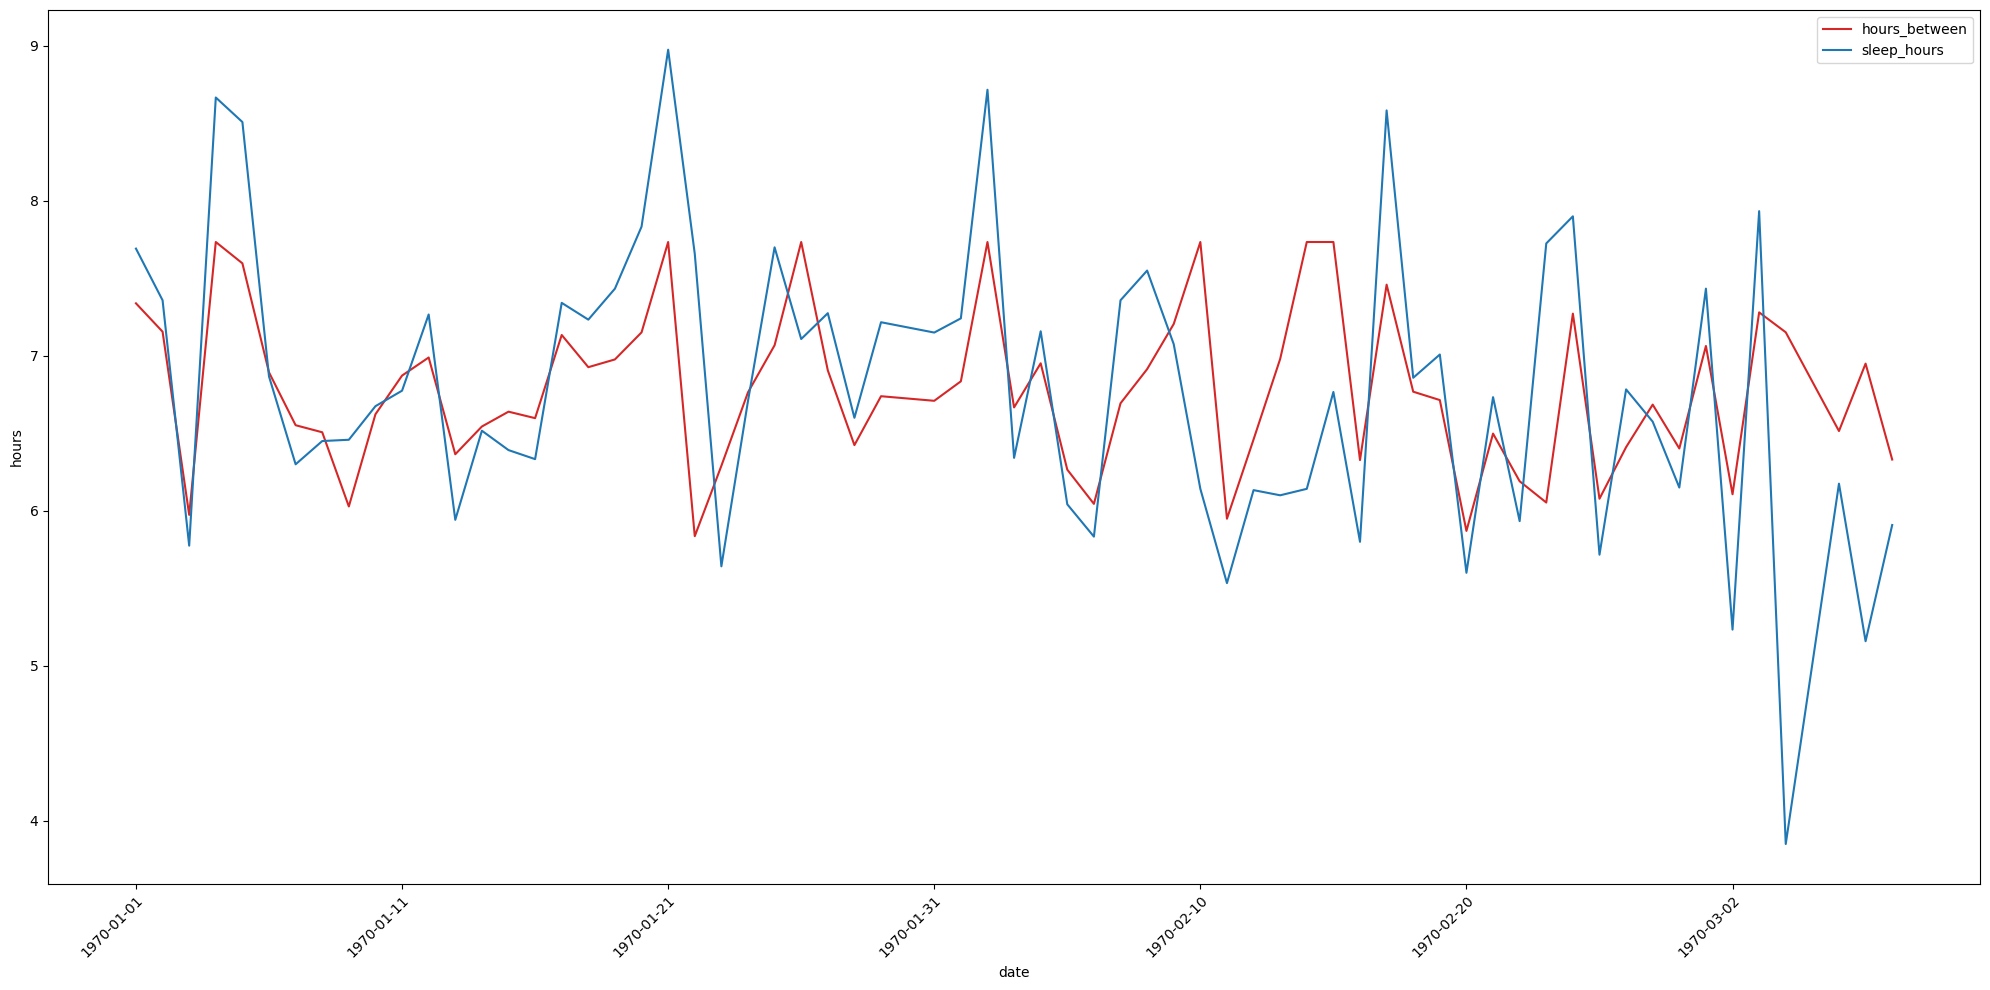

In [105]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

slice = df.copy()
#slice = slice.set_index("date")['12-01-2021':].reset_index()
slice['date'] = pd.to_datetime(slice['date'])

fig, ax1 = plt.subplots(figsize=(20, 10))

ax1.set_xlabel('date')
ax1.set_ylabel('hours')

# Plot hours_between with red color
ax1.plot(slice.index, slice['hours_between'], color='tab:red', label='hours_between')

# Plot sleep_hours with blue color on the same axis
ax1.plot(slice.index, slice['sleep_hours'], color='tab:blue', label='sleep_hours')

# Set up the legend
ax1.legend()

# Format the x-axis to display dates
date_fmt = mdates.DateFormatter('%Y-%m-%d')
ax1.xaxis.set_major_formatter(date_fmt)

# Rotate and align the x-axis labels
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

fig.tight_layout()  # otherwise the right y-label is slightly clipped0
plt.show()


In [22]:
df = rr.copy()
df = df[["startDate", "endDate", "value"]] #
df['startDate'] = pd.to_datetime(df['startDate']) 
df['endDate'] = pd.to_datetime(df['endDate'])

# Filter value on less than 17
#df = df[df["value"] < 18]

df["date"] = (df["startDate"] - pd.Timedelta(hours=12)).dt.date

df["diff"] = (df["startDate"].shift(-1) - df["endDate"]).dt.seconds / 3600
# df["diff"] = (df["startDate"] - df["endDate"].shift(1)).dt.seconds / 3600


df = df[df["value"] < 18]
df = df[df["diff"] < 12]

df = df.groupby("date").agg({"diff": "sum"}).reset_index().sort_values(by="date")

true = pd.read_csv("./data/train.csv", low_memory=False)
true["date"] = pd.to_datetime(true["date"])
df["date"] = pd.to_datetime(df["date"])

df = df.merge(true, on="date", how="left")

df = df.dropna()
print(df.head())

from sklearn.metrics import mean_squared_error
import numpy as np

print('RMSE: ', np.sqrt(mean_squared_error(df["diff"], df["sleep_hours"])))


NameError: name 'rr' is not defined

In [ ]:


# Drop where sleep_hours is NaN
df = df.dropna(subset=['sleep_hours'])
df

In [ ]:


(df["hrs_min_min"] + df["hrs_min_max"] + df["hrs_max_min"] + df["hrs_max_max"])/4

In [32]:
def _calculate_night_hours(df):
    
    df['startDate'] = pd.to_datetime(df['startDate']).dt.tz_localize(None)
    df['endDate'] = pd.to_datetime(df['endDate']).dt.tz_localize(None)
    
    df = df[df["value"] < 18]
    
    df = df.sort_values(by=['startDate', 'endDate'])
    
    # Get the date range in the dataframe
    min_date = df['startDate'].min().date()
    max_date = df['endDate'].max().date()

    # Initialize an empty list to store the results
    results = []

    # Loop through each date in the range
    for date in pd.date_range(min_date, max_date):
        # startSleep time boundaries - Based on analysis of train_detailed
        start_day = pd.Timestamp.combine(date, pd.Timestamp('21:30:00').time())
        end_day = pd.Timestamp.combine(date + pd.DateOffset(1), pd.Timestamp('02:30:00').time())
        # endSleep time boundaries - Based on analysis of train_detailed
        start_night = pd.Timestamp.combine(date + pd.DateOffset(1), pd.Timestamp('05:30:00').time())
        end_night = pd.Timestamp.combine(date + pd.DateOffset(1), pd.Timestamp('10:30:00').time())
        # print(f'date {date}, start sleep {start_day}, end sleep {end_day}, start awake {start_night}, end awake {end_night}')
        
        # Filter the dataframe for start of sleep
        mask_startSleep_startDate = (df['startDate'] >= start_day) & (df['startDate'] <= end_day)
        filtered_startSleep_startDate = df[mask_startSleep_startDate]

        mask_startSleep_endDate = (df['endDate'] >= start_day) & (df['endDate'] <= end_day)
        filtered_startSleep_endDate = df[mask_startSleep_endDate]

        # Filter the dataframe for end of sleep
        mask_endSleep_startDate = (df['startDate'] >= start_night) & (df['startDate'] <= end_night)
        filtered_endSleep_startDate = df[mask_endSleep_startDate]
        
        mask_endSleep_endDate = (df['endDate'] >= start_night) & (df['endDate'] <= end_night)
        filtered_endSleep_endDate = df[mask_endSleep_endDate]
        
        # Append the results to the list
        results.append({
            'date': date,
            'startSleep_min_startDate': filtered_startSleep_startDate['startDate'].min(),
            'startSleep_max_startDate': filtered_startSleep_startDate['startDate'].max() ,
            'startSleep_min_endDate': filtered_startSleep_endDate['endDate'].min(),
            'startSleep_max_endDate': filtered_startSleep_endDate['endDate'].max(), 
            'endSleep_min_startDate': filtered_endSleep_startDate['startDate'].min(),
            'endSleep_max_startDate': filtered_endSleep_startDate['startDate'].max(),
            'endSleep_min_endDate': filtered_endSleep_endDate['endDate'].min(),
            'endSleep_max_endDate': filtered_endSleep_endDate['endDate'].max(),
        })

    # Convert the results to a dataframe and return
    result_df = pd.DataFrame(results)
    
    start_sleep_columns = [
        "startSleep_min_startDate",
        "startSleep_max_startDate",
        "startSleep_min_endDate",
        "startSleep_max_endDate",
    ]   

    end_sleep_columns = [
        "endSleep_min_startDate",
        "endSleep_max_startDate",
        "endSleep_min_endDate",
        "endSleep_max_endDate",
    ]
    
    # Clips (calculated from last 3 months)
    avg_sleep = 6.78525641025641
    max_sleep = 7.734282511512526
    min_sleep = 5.836230309000293
    
    for i, start_col in enumerate(start_sleep_columns):
        for j, end_col in enumerate(end_sleep_columns):
            result_df[f"diff_{i}_{j}"] = (result_df[end_col] - result_df[start_col]).dt.total_seconds() / 3600
            result_df[f"diff_{i}_{j}"] = ((avg_sleep + result_df[f"diff_{i}_{j}"])/2).clip(lower=min_sleep, upper=max_sleep)
    
    for col in start_sleep_columns:
        result_df[f"{col}_hr"] = result_df[col].dt.hour + result_df[col].dt.minute / 60 + result_df[col].dt.second / 3600
        result_df[f"{col}_hr"] = result_df[f"{col}_hr"].apply(lambda x: x + 24 if x < 12 else x) # If the hour is less than 12, add 24 to it
       
    for col in end_sleep_columns:
        result_df[f"{col}_hr"] = result_df[col].dt.hour + result_df[col].dt.minute / 60 + result_df[col].dt.second / 3600

    result_df = result_df.drop(columns = ['startSleep_min_startDate', 'startSleep_max_startDate', 'startSleep_min_endDate', 'startSleep_max_endDate', 'endSleep_min_startDate', 'endSleep_max_startDate', 'endSleep_min_endDate', 'endSleep_max_endDate']).reset_index(drop=True)
    
    return result_df
    
    
resp = _calculate_night_hours(rr.copy())
resp.head()

,date,diff_0_0,diff_0_1,diff_0_2,diff_0_3,diff_1_0,diff_1_1,diff_1_2,diff_1_3,diff_2_0,...,diff_3_2,diff_3_3,startSleep_min_startDate_hr,startSleep_max_startDate_hr,startSleep_min_endDate_hr,startSleep_max_endDate_hr,endSleep_min_startDate_hr,endSleep_max_startDate_hr,endSleep_min_endDate_hr,endSleep_max_endDate_hr
0,2021-10-25,6.184156,7.398878,6.184156,7.398878,5.83623,6.200684,5.83623,6.200684,6.184156,...,5.83623,6.200684,23.935000,26.331389,23.935000,26.331389,5.518056,7.947500,5.518056,7.947500
1,2021-10-26,6.071795,7.215962,6.071795,7.215962,5.83623,6.150823,5.83623,6.150823,6.071795,...,5.83623,6.150823,24.308056,26.438333,24.308056,26.438333,5.666389,7.954722,5.666389,7.954722
2,2021-10-27,5.836230,6.034156,5.836230,6.034156,5.83623,5.836230,5.83623,5.836230,5.836230,...,5.83623,5.836230,24.782222,26.321389,24.782222,26.321389,5.641111,6.065278,5.641111,6.065278
3,2021-10-28,6.628739,7.734283,6.628739,7.734283,5.83623,6.262906,5.83623,6.262906,6.628739,...,5.83623,6.262906,23.065556,26.442778,23.065556,26.442778,5.537778,8.183333,5.537778,8.183333
4,2021-10-29,6.305128,7.656934,6.305128,7.656934,5.83623,6.404712,5.83623,6.404712,6.305128,...,5.83623,6.404712,23.806111,26.310556,23.806111,26.310556,5.631111,8.334722,5.631111,8.334722


In [34]:
resp.diff_0_3.isna().value_counts()

diff_0_3
False    433
True      76
Name: count, dtype: int64

In [1]:
from data import POG4_Dataset

data = POG4_Dataset()

INFO - Creating XML data
INFO - Creating activity data
INFO - Missing days: 87
INFO - Featurizing time series data
INFO - Creating interactions...


In [5]:
data.train.slp_RespiratoryRate_diff_0_3.isna().value_counts()

slp_RespiratoryRate_diff_0_3
True     2335
False      64
Name: count, dtype: int64

In [5]:
import pandas as pd

train = data.train[(data.train['date'] >= pd.to_datetime('2020-09-25').date()) & (data.train['date'] <= pd.to_datetime('2021-11-30').date())]
test = data.train[(data.train['date'] >= pd.to_datetime('2021-12-01').date()) & (data.train['date'] <= pd.to_datetime('2021-12-31').date())]
# Using cross-validation so concat the train and test sets
X_train = train.drop(['sleep_hours', 'date'], axis=1)
y_train = train.sleep_hours.fillna(method="ffill").fillna(method="bfill").fillna(6.5)
X_test = test.drop(['sleep_hours', 'date'], axis=1)
y_test = test.sleep_hours.fillna(method="ffill").fillna(method="bfill").fillna(6.5)

NameError: name 'data' is not defined

In [4]:

train["date"] = pd.to_datetime(train["date"])
resp["date"] = pd.to_datetime(resp["date"])
resp = resp.merge(train, on='date', how='inner')
resp.head()

resp_X = resp.drop(['sleep_hours', 'date'], axis=1)
resp_y = resp.sleep_hours.fillna(method="ffill").fillna(method="bfill").fillna(6.5)

NameError: name 'train' is not defined

In [79]:
for i in resp_X.columns:
    print(i)

diff_0_0
diff_0_1
diff_0_2
diff_0_3
diff_1_0
diff_1_1
diff_1_2
diff_1_3
diff_2_0
diff_2_1
diff_2_2
diff_2_3
diff_3_0
diff_3_1
diff_3_2
diff_3_3
startSleep_min_startDate_hr
startSleep_max_startDate_hr
startSleep_min_endDate_hr
startSleep_max_endDate_hr
endSleep_min_startDate_hr
endSleep_max_startDate_hr
endSleep_min_endDate_hr
endSleep_max_endDate_hr
is_workday
slp_BasalEnergyBurned_08_55_00
doy_sin
slp_ActiveEnergyBurned_07_05_00
slp_ActiveEnergyBurned_02_15_00
slp_ActiveEnergyBurned_07_20_00
slp_HeartRate_00_50_00
slp_HeartRate_07_05_00
slp_ActiveEnergyBurned_07_00_00
slp_HeartRate_01_55_00
slp_DistanceWalkingRunning_22_45_00
slp_HeartRate_02_20_00
slp_EnvironmentalAudioExposure_23_30_00
slp_ActiveEnergyBurned_22_50_00
slp_BasalEnergyBurned_05_15_00
slp_HeartRate_07_10_00
slp_EnvironmentalAudioExposure_00_50_00
slp_BasalEnergyBurned_09_00_00
slp_EnvironmentalAudioExposure_23_10_00
slp_HeartRate_06_30_00
slp_ActiveEnergyBurned_00_15_00
slp_EnvironmentalAudioExposure_07_25_00
slp_HeartR

In [3]:
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

# SVM with RBF kernel
from sklearn.svm import SVR

#KNN Regressor
from sklearn.neighbors import KNeighborsRegressor

params = {
    "eta": 0.29930198166014205,
    "alpha": 0.3753739726241434,
    "lmbda": 7.808039770750299,
    "max_depth": 2,
    "subsample": 0.3134605121170969,
    "n_estimators": 835,
    "learning_rate": 0.03008760669411828,
    "colsample_bytree": 0.313312609952353
}


imputer = SimpleImputer(strategy="median")
scaler = RobustScaler()
#XGBRegressor(**params, tree_method='gpu_hist', gpu_id=0, verbosity=0)
model = XGBRegressor(**params, tree_method='gpu_hist', gpu_id=0, verbosity=0)
# Baseline 0.95

pipe = Pipeline([
    ('imputer', imputer),
    ('scaler', scaler),
    ('model', model)
])


X = true["hours_between"].values.reshape(-1, 1)
y = true["sleep_hours"].values.ravel()

X_sub = sub["hours_between"].values.reshape(-1, 1)

# Fit the model to the training data
cv_scores = cross_val_score(pipe, resp_X, resp_y, cv=3, scoring="neg_mean_squared_error")
rmse_scores = np.sqrt(-cv_scores)
avg_rmse = np.mean(rmse_scores)
# Predict on the test set
# y_pred = pipe.predict(X_test)

# Calculate the mean squared error
#mse = mean_squared_error(y_test, y_pred)
print(f"Mean squared error: {avg_rmse}")

NameError: name 'resp_X' is not defined

In [68]:
# Predictions 
pipe.fit(resp_X, resp_y)

pipe.predict(X_sub)

/home/sebastian/mambaforge/envs/pog4-sleep/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


ValueError: X has 1 features, but SimpleImputer is expecting 265 features as input.

In [11]:
def _calculate_night_hours(orig_df):
    df = orig_df.copy()
    
    df['startDate'] = pd.to_datetime(df['startDate']).dt.tz_localize(None)
    df['endDate'] = pd.to_datetime(df['endDate']).dt.tz_localize(None)
    
    df = df.sort_values(by=['startDate', 'endDate'])
    
    # Get the date range in the dataframe
    min_date = df['startDate'].min().date()
    max_date = df['endDate'].max().date()

    # Initialize an empty list to store the results
    results = []

    # Loop through each date in the range
    if pd.notnull(min_date) and pd.notnull(max_date):

        for date in pd.date_range(min_date, max_date):
            # startSleep time boundaries - Based on analysis of train_detailed
            start_day = pd.Timestamp.combine(date, pd.Timestamp('21:30:00').time())
            end_day = pd.Timestamp.combine(date + pd.DateOffset(1), pd.Timestamp('02:30:00').time())
            # endSleep time boundaries - Based on analysis of train_detailed
            start_night = pd.Timestamp.combine(date + pd.DateOffset(1), pd.Timestamp('05:30:00').time())
            end_night = pd.Timestamp.combine(date + pd.DateOffset(1), pd.Timestamp('10:30:00').time())
            # print(f'date {date}, start sleep {start_day}, end sleep {end_day}, start awake {start_night}, end awake {end_night}')

            # Filter the dataframe for start of sleep
            mask_startSleep_startDate = (df['startDate'] >= start_day) & (df['startDate'] <= end_day)
            filtered_startSleep_startDate = df[mask_startSleep_startDate]

            mask_startSleep_endDate = (df['endDate'] >= start_day) & (df['endDate'] <= end_day)
            filtered_startSleep_endDate = df[mask_startSleep_endDate]

            # Filter the dataframe for end of sleep
            mask_endSleep_startDate = (df['startDate'] >= start_night) & (df['startDate'] <= end_night)
            filtered_endSleep_startDate = df[mask_endSleep_startDate]

            mask_endSleep_endDate = (df['endDate'] >= start_night) & (df['endDate'] <= end_night)
            filtered_endSleep_endDate = df[mask_endSleep_endDate]

            # Append the results to the list
            results.append({
                'date': date,
                'startSleep_min_startDate': filtered_startSleep_startDate['startDate'].min(),
                'startSleep_max_startDate': filtered_startSleep_startDate['startDate'].max() ,
                'startSleep_min_endDate': filtered_startSleep_endDate['endDate'].min(),
                'startSleep_max_endDate': filtered_startSleep_endDate['endDate'].max(), 
                'endSleep_min_startDate': filtered_endSleep_startDate['startDate'].min(),
                'endSleep_max_startDate': filtered_endSleep_startDate['startDate'].max(),
                'endSleep_min_endDate': filtered_endSleep_endDate['endDate'].min(),
                'endSleep_max_endDate': filtered_endSleep_endDate['endDate'].max(),
            })

        # Convert the results to a dataframe and return
        result_df = pd.DataFrame(results)

        start_sleep_columns = [
            "startSleep_min_startDate",
            "startSleep_max_startDate",
            "startSleep_min_endDate",
            "startSleep_max_endDate",
        ]   

        end_sleep_columns = [
            "endSleep_min_startDate",
            "endSleep_max_startDate",
            "endSleep_min_endDate",
            "endSleep_max_endDate",
        ]

        # Clips (calculated from last 3 months)
        avg_sleep = 6.78525641025641
        max_sleep = 7.734282511512526
        min_sleep = 5.836230309000293

        for i, start_col in enumerate(start_sleep_columns):
            for j, end_col in enumerate(end_sleep_columns):
                result_df[f"diff_{i}_{j}"] = (result_df[end_col] - result_df[start_col]).dt.total_seconds() / 3600
                result_df[f"diff_{i}_{j}"] = ((avg_sleep + result_df[f"diff_{i}_{j}"])/2).clip(lower=min_sleep, upper=max_sleep)

        for col in start_sleep_columns:
            result_df[f"{col}_hr"] = result_df[col].dt.hour + result_df[col].dt.minute / 60 + result_df[col].dt.second / 3600
            result_df[f"{col}_hr"] = result_df[f"{col}_hr"].apply(lambda x: x + 24 if x < 12 else x) # If the hour is less than 12, add 24 to it

        for col in end_sleep_columns:
            result_df[f"{col}_hr"] = result_df[col].dt.hour + result_df[col].dt.minute / 60 + result_df[col].dt.second / 3600

        result_df = result_df.drop(columns = ['startSleep_min_startDate', 'startSleep_max_startDate', 'startSleep_min_endDate', 'startSleep_max_endDate', 'endSleep_min_startDate', 'endSleep_max_startDate', 'endSleep_min_endDate', 'endSleep_max_endDate']).reset_index(drop=True)
    
    else:
        result_df = pd.DataFrame(columns=['date', 'diff_0_0', 'diff_0_1', 'diff_0_2', 'diff_0_3', 'diff_1_0', 'diff_1_1', 'diff_1_2', 'diff_1_3', 'diff_2_0', 'diff_2_1', 'diff_2_2', 'diff_2_3', 'diff_3_0', 'diff_3_1', 'diff_3_2', 'diff_3_3', 'startSleep_min_startDate_hr', 'startSleep_max_startDate_hr', 'startSleep_min_endDate_hr', 'startSleep_max_endDate_hr', 'endSleep_min_startDate_hr', 'endSleep_max_startDate_hr', 'endSleep_min_endDate_hr', 'endSleep_max_endDate_hr'])
    
    return result_df


_calculate_night_hours(rr[rr["value"] < 18])

,date,diff_0_0,diff_0_1,diff_0_2,diff_0_3,diff_1_0,diff_1_1,diff_1_2,diff_1_3,diff_2_0,...,diff_3_2,diff_3_3,startSleep_min_startDate_hr,startSleep_max_startDate_hr,startSleep_min_endDate_hr,startSleep_max_endDate_hr,endSleep_min_startDate_hr,endSleep_max_startDate_hr,endSleep_min_endDate_hr,endSleep_max_endDate_hr
0,2021-10-25,6.184156,7.398878,6.184156,7.398878,5.83623,6.200684,5.83623,6.200684,6.184156,...,5.83623,6.200684,23.935000,26.331389,23.935000,26.331389,5.518056,7.947500,5.518056,7.947500
1,2021-10-26,6.071795,7.215962,6.071795,7.215962,5.83623,6.150823,5.83623,6.150823,6.071795,...,5.83623,6.150823,24.308056,26.438333,24.308056,26.438333,5.666389,7.954722,5.666389,7.954722
2,2021-10-27,5.836230,6.034156,5.836230,6.034156,5.83623,5.836230,5.83623,5.836230,5.836230,...,5.83623,5.836230,24.782222,26.321389,24.782222,26.321389,5.641111,6.065278,5.641111,6.065278
3,2021-10-28,6.628739,7.734283,6.628739,7.734283,5.83623,6.262906,5.83623,6.262906,6.628739,...,5.83623,6.262906,23.065556,26.442778,23.065556,26.442778,5.537778,8.183333,5.537778,8.183333
4,2021-10-29,6.305128,7.656934,6.305128,7.656934,5.83623,6.404712,5.83623,6.404712,6.305128,...,5.83623,6.404712,23.806111,26.310556,23.806111,26.310556,5.631111,8.334722,5.631111,8.334722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504,2023-03-13,5.836230,6.723184,5.836230,6.723184,5.83623,6.723184,5.83623,6.723184,5.836230,...,5.83623,6.723184,25.223889,25.223889,25.223889,25.223889,5.503056,7.885000,5.503056,7.885000
505,2023-03-14,6.223739,6.903600,6.223739,6.903600,5.83623,5.836230,5.83623,5.836230,6.223739,...,5.83623,5.836230,24.046111,26.496111,24.046111,26.496111,5.708333,7.068056,5.708333,7.068056
506,2023-03-15,5.951100,7.009989,5.951100,7.009989,5.83623,6.095684,5.83623,6.095684,5.951100,...,5.83623,6.095684,24.585833,26.414444,24.585833,26.414444,5.702778,7.820556,5.702778,7.820556
507,2023-03-16,5.836230,6.668462,5.836230,6.668462,5.83623,6.257350,5.83623,6.257350,5.836230,...,5.83623,6.257350,25.352778,26.175000,25.352778,26.175000,5.639444,7.904444,5.639444,7.904444


In [12]:

_calculate_night_hours(rr[rr["value"] < 18]).diff_0_3.isna().value_counts()

diff_0_3
False    433
True      76
Name: count, dtype: int64

# Clustering

In [1]:
from data import POG4_Dataset

data = POG4_Dataset()
#data.create_lags()


INFO - Creating XML data
INFO - Creating activity data
INFO - Missing days: 3
INFO - Featurizing time series data
INFO - Creating interactions...


In [2]:
X = data.train.drop(['sleep_hours', 'date'], axis=1, errors='ignore')
y = data.train.sleep_hours.fillna(method="ffill").fillna(method="bfill").fillna(7.0)

In [12]:
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn import pipeline
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans, SpectralClustering
from xgboost import XGBRegressor
from hdbscan import HDBSCAN


imputer = SimpleImputer(strategy='median')
scaler = RobustScaler()

class ClusteringTransformer(TransformerMixin, BaseEstimator):
    def __init__(self):
        self.cluster = HDBSCAN()
        self.scaler = RobustScaler()

    def fit(self, X, y=None):
        self.cluster.fit(X)
        cluster_labels = self.cluster.labels_.reshape(-1, 1)
        self.scaler.fit(cluster_labels)
        return self

    def transform(self, X):
        cluster_labels = self.cluster.fit_predict(X).reshape(-1, 1)
        cluster_labels_scaled = self.scaler.transform(cluster_labels)
        X_new = np.column_stack((X, cluster_labels_scaled))
        return X_new


cluster = ClusteringTransformer()

params = {
    "alpha": 0.15500515308718543,
    "lambda": 9.4553069371423,
    "max_depth": 64,
    "subsample": 0.3388935978957399,
    "n_estimators": 6148,
    "learning_rate": 0.2994369042411531,
    "colsample_bytree": 0.4745469122792432
}

class LastColumnScaler(TransformerMixin, BaseEstimator):
    def __init__(self):
        self.scaler = RobustScaler()

    def fit(self, X, y=None):
        # Fit the scaler only on the last column (DBSCAN column)
        self.scaler.fit(X[:, -1:])
        return self

    def transform(self, X):
        # Scale only the last column
        X_last_col_scaled = self.scaler.transform(X[:, -1:])
        X_new = np.column_stack((X[:, :-1], X_last_col_scaled))
        return X_new

last_col_scaler = LastColumnScaler()

xgb = XGBRegressor(**params, tree_method='gpu_hist', gpu_id=0)

pipe = pipeline.Pipeline([
    ('imputer', imputer),
    ('scaler', scaler),
    ('cluster', cluster),
    ('xgb', xgb)
])



In [13]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

# Perform cross-validation and calculate metrics
cv_scores = cross_val_score(pipe, X, y, cv=3, scoring="neg_mean_squared_error")
rmse_scores = np.sqrt(-cv_scores)
avg_rmse = np.mean(rmse_scores)

print(f"Average RMSE: {avg_rmse}")

Average RMSE: 0.6695312787606865


In [15]:
feat1 = ["date", "sleep_hours", "is_workday", "day_of_week",
                    'slp_RespiratoryRate_endSleep_max_startDate_hr', 
                    'slp_DistanceWalkingRunning_sum_hrs_between', 
                    'slp_AppleStandTime_startSleep_max_startDate_hr', 
                    'slp_AppleExerciseTime_sum_hrs_between', 
                    'slp_ActiveEnergyBurned_sum_hrs_between', 
                    'slp_AppleStandHour_max_hrs_between', 
                    'AppleExerciseTime', 
                    'slp_BasalEnergyBurned_count_hrs_between', 
                    'slp_RespiratoryRate_startSleep_min_endDate_hr', 
                    'slp_AppleStandTime_startSleep_min_startDate_hr', 
                    'slp_AppleStandTime_startSleep_min_endDate_hr', 
                    'slp_FlightsClimbed_sum_hrs_between', 
                    'slp_EnvironmentalAudioExposure_endSleep_max_endDate_hr', 
                    'RespiratoryRate', 
                    'day_of_year', 
                    'slp_StepCount_startSleep_max_startDate_hr', 
                    'slp_AppleStandTime_max_hrs_between', 
                    'slp_StepCount_startSleep_max_endDate_hr', 
                    'slp_ActiveEnergyBurned_count_hrs_between', 
                    'slp_RespiratoryRate_startSleep_min_startDate_hr', 
                    'BasalEnergyBurned', 
                    'min_startDate_max_hr', 
                    'slp_AppleStandTime_startSleep_max_endDate_hr', 
                    'slp_AppleStandTime_sum_hrs_between', 
                    'slp_BasalEnergyBurned_sum_hrs_between', 
                    'slp_StepCount_endSleep_min_startDate_hr', 
                    'slp_RespiratoryRate_endSleep_min_startDate_hr', 
                    'slp_StepCount_sum_hrs_between', 
                    'slp_BasalEnergyBurned_endSleep_min_startDate_hr', 
                    'AppleStandTime', 
                    'slp_AppleExerciseTime_max_hrs_between', 
                    'slp_RespiratoryRate_endSleep_max_endDate_hr', 
                    'ActiveEnergyBurned', 
                    'distance_per_step', 
                    'slp_RespiratoryRate_endSleep_min_endDate_hr', 
                    'min_endDate_max_hr', 
                    'OxygenSaturation', 
                    'doy_sin']

feat2 = ["date", "sleep_hours", "is_workday", "day_of_week",
                "OxygenSaturation",
                "slp_AppleStandTime_startSleep_max_endDate_hr",
                "slp_StepCount_23_15_00",
                "slp_RespiratoryRate_endSleep_max_startDate_hr",
                "slp_HeartRate_07_35_00",
                "slp_AppleStandTime_startSleep_min_endDate_hr",
                "slp_AppleStandTime_count_hrs_between",
                "min_startDate_max_hr",
                "slp_OxygenSaturation_01_10_00",
                "min_endDate_max_hr",
                "slp_BasalEnergyBurned_01_00_00",
                "slp_ActiveEnergyBurned_23_35_00",
                "slp_ActiveEnergyBurned_00_40_00",
                "slp_AppleStandTime_startSleep_max_startDate_hr",
                "slp_OxygenSaturation_01_35_00",
                "slp_StepCount_05_50_00",
                "slp_BasalEnergyBurned_count_hrs_between",
                "slp_RespiratoryRate_endSleep_max_endDate_hr",
                "slp_StepCount_02_40_00",
                "slp_DistanceWalkingRunning_21_25_00",
                "slp_OxygenSaturation_23_55_00",
                "slp_ActiveEnergyBurned_23_45_00",
                "slp_ActiveEnergyBurned_01_30_00",
                "slp_ActiveEnergyBurned_04_05_00",
                "slp_BasalEnergyBurned_21_05_00",
                "AppleStandTime",
                "slp_AppleStandTime_21_10_00",
                "slp_FlightsClimbed_22_50_00",
                "slp_StepCount_startSleep_max_endDate_hr",
                "slp_EnvironmentalAudioExposure_00_55_00",
                "slp_BasalEnergyBurned_sum_hrs_between",
                "slp_ActiveEnergyBurned_01_05_00",
                "slp_ActiveEnergyBurned_23_00_00",
                "slp_ActiveEnergyBurned_00_45_00",
                "slp_RespiratoryRate_startSleep_min_startDate_hr",
                "slp_AppleStandTime_startSleep_min_startDate_hr",
                "slp_ActiveEnergyBurned_21_05_00",
                "slp_RespiratoryRate_00_00_00",
                "slp_AppleStandTime_sum_hrs_between",
                "slp_ActiveEnergyBurned_01_25_00",
                "slp_HeartRate_01_50_00",
                "slp_ActiveEnergyBurned_21_25_00",
                "slp_StepCount_sum_hrs_between",
                "slp_FlightsClimbed_sum_hrs_between",
                "slp_EnvironmentalAudioExposure_23_30_00",
                "slp_ActiveEnergyBurned_06_45_00",
                "slp_AppleExerciseTime_max_hrs_between",
                "slp_RespiratoryRate_07_55_00",
                "slp_RespiratoryRate_startSleep_min_endDate_hr",
                "RespiratoryRate",
                "day_of_year",
                "slp_AppleStandTime_max_hrs_between",
                "slp_OxygenSaturation_01_05_00",
                "slp_HeartRate_07_45_00",
                "slp_ActiveEnergyBurned_05_25_00",
                "slp_StepCount_23_10_00",
                "slp_DistanceWalkingRunning_05_20_00",
             ]

# get combined unique features
feat = list(set(feat1 + feat2))

In [18]:
data.train.shape

(68, 37)